# Imports

In [88]:
import numpy as np 
import matplotlib.pyplot as plt  
import pandas as pd
import scipy.stats as stats 
import sympy as sy 
from scipy.optimize import fsolve
import time
import os

In [ ]:
from functions.plot import *
from models.model import model 
from models.model import model_gamma_4_16, model_gamma_02_08

# Constants

In [ ]:
# # We want to take time horizon as 100 years which is 36525 days including the years with more or less days
u0List = [16000 * i for i in [0,1,2,3,4,5]]
thetaList = [0.01, 0.1, 0.5, 0.9, 1 ,2]

### Use Monte Carlo simulation to investigate the influence of the premium c and the initial capital u on the ruin probability ψ(u).

In [ ]:
# The model is developed in this document 
# Refer to "/src/models/model.py"


In [109]:
# Find the time horizon (we found it to be 2000 )
LAMBDA_ARRIVAL= 4
CLAIMSIZE_MEAN = 16000 
TIME_HORIZON = 2000  
# we will try to find a time horizon that is not very big, but enough to simulate 
# model(2000, lambda_arrival, claimSize_mean).simulate((16000,), (0.01,))

Claim Sizes ~ U(a=10000,b=22000)


In [ ]:
# TODO: Uncomment 
# q1_model = model(TIME_HORIZON, LAMBDA_ARRIVAL, CLAIMSIZE_MEAN)
# q1_model.set_name("q1_model")
# df = q1_model.simulate(u0List, thetaList)
# df

In [ ]:
# TODO: REMOVE THIS BOX SINCE THIS IS JUST DEBUG
df = pd.read_csv("./results/q1_model_simulation_results.csv")

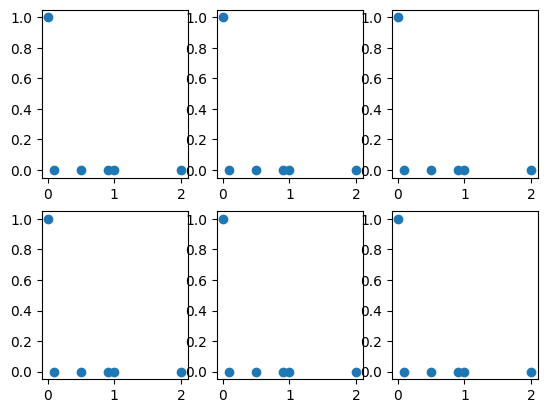

In [ ]:
# effect of theta 


fig, axs = plt.subplots(nrows=2, ncols=3)
axs = axs.flatten() 

for i in range(len(df.index)): 
    axs[i].scatter(x=df.columns, y=df[df.index==df.index[i]])



# df.plot()
# plt.scatter(x=df.columns, y=df[df.index==])
# plt.scatter(x=df.columns, y=df[df.index==])
# df[df.index==0]
# plt.scatter(x=df.columns, y=df[df.index==0],)


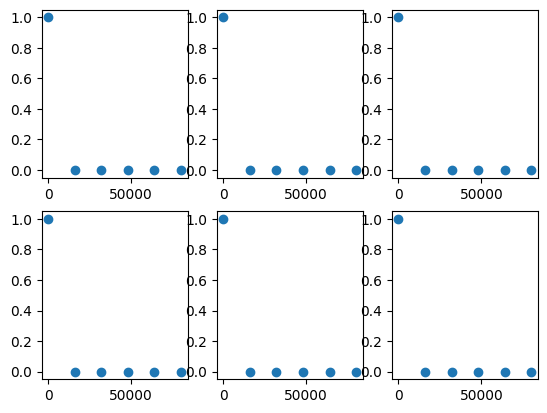

In [96]:
# Effect of  
fig, axs = plt.subplots(nrows=2, ncols=3)
axs = axs.flatten() 

for i in range(len(df.index)): 
    axs[i].scatter(x=df.index, y=df[df.index==df.index[i]])

### Determine the distribution of the maximal aggregate loss in case of Erlang-2 distributed claim sizes with mean 16 thousand PLZ, and give an explicit expression for the ruin probability ψE2(u).

In [97]:
# R, t = sy.symbols("R theta")

# eq = sy.Eq(16000 * R * (1 + t) + 1, 1 / ((1 - 8000 * R) ** 2))
# # sy.solve(eq, R)[2].subs({t:0}).evalf()
# eq1 = sy.solve(eq, R)[1]
# eq2 = sy.solve(eq, R)[2]

# # thetaList = [i / 1000 for i in range(1,10000)] # we assume that theta>0
# # plt.plot(thetaList, [eq1.subs({t:theta})for theta in thetaList], color="b")
# # plt.plot(thetaList, [eq2.subs({t:theta})for theta in thetaList], color="r")
# # thetaList
# eq1.subs({t:0.0001})

In [98]:
# a, b, theta, R = sy.symbols("a b theta R")
# expr1 = 1 + (1 + theta) * 16000 * R
# expr2 =  (sy.exp(b * R) - sy.exp(a * R)) / (R * (b-a))

# eq = sy.Eq(expr1, expr2)
# eq

In [99]:

# # Define the equation as a Python function
# def equation(R, theta, a=10000, b=22000, E_Xi=16000):
#     return 1 + (1 + theta) * E_Xi * R - (np.exp(b * R) - np.exp(a * R)) / (R * (b - a))

# def check_equivalence(sol, theta_value):

#     val1 = expr1.subs({a:10000, b:22000, R:sol, theta:theta_value}).evalf()
#     val2 = expr2.subs({a:10000, b:22000, R:sol }).evalf()
#     f = lambda x: np.float128(x)

#     return np.isclose(f(val1),f(val2), atol=1e-9, rtol=1e-9)

In [100]:
# # We find the smallest R possible within 

# theta_value = 1  # Replace with the desired theta value

# sol = np.inf
# lastValue = None 
# for i in range(600, 0, -1): # this is accurate in between [1e300, 1e-300]   
#     val = fsolve(equation, x0=float(f"1e{i-300}"), args=(theta_value))[0]
    
#     if val < 0: # we are looking for the positive solution 
#         continue

#     if (val < sol) and (check_equivalence(val, theta_value)):
#         sol = val
#         lastValue = i-300

# # for i in range(10000, 1, -1): # this is just to see if we can find a more accurate value which is between 
# #     val = fsolve(equation, x0=float(f"1e{i-300}"), args=(theta_value))[0]
    
# #     if val < 0: # we are looking for the positive solution 
# #         continue

# #     if (val < sol) and (check_equivalence(val, theta_value)):
# #         sol = val
# #         lastValue = i-300

# sol
# # lastValue

In [101]:
# # # [i/1000 for i in range(1, 1001)]
# # for i in range(10000-1, 1, -1): 
# #     if (i/10000 > 0.1 ) and (i/10000 < 10)
# #     print(f"{i/10000}e{lastValue}") 
# #     # break

# # this checks every value for x0, that is between 10e300 to 0.1e-300# with am margin of 0.1
# sol = np.inf
# lastValue = None 
# for i in range(600, 0, -1): # this is accurate in between [0.2e-300, 9.9e300] with step 0.1 
#     for j in range(2, 100): 

#         val = fsolve(equation, x0=float(f"{j/10}e{i-300}"), args=(theta_value))[0]
        
#         if val < 0: # we are looking for the positive solution 
#             continue

#         if (val < sol) and (check_equivalence(val, theta_value)):
#             sol = val
#             lastValue = f"{j/10}e{i-300}"

In [102]:
# print(sol, lastValue)

### Use Monte Carlo simulation to investigate the influence of the distribution of the inter- claim times on the ruin probability ψ(u). 

In [ ]:
from models.model import model_gamma_4_16, model_gamma_02_08

In [ ]:
mg416 = model_gamma_4_16(TIME_HORIZON, LAMBDA_ARRIVAL, CLAIMSIZE_MEAN)
mg416.set_name("mg416")
mg416.simulate(u0List, thetaList)

df = pd.read_csv("./results/q1_model_simulation_results.csv")


TypeError: model.__init__() missing 3 required positional arguments: 'time_horizon', 'lambda_arrival', and 'claimSize_mean'

In [ ]:
mg0208 = model_gamma_02_08(TIME_HORIZON, LAMBDA_ARRIVAL, CLAIMSIZE_MEAN)
mg0208.set_name("mg0208")
mg0208.simulate(u0List, thetaList)

Claim Sizes ~ U(a=10000,b=22000)

Time Horizon: 2 days.
u0 List: (16000,)
Safety Loading List: (1,)


Time taken for 1000 simulations: 0.6916558742523193 seconds, this is equal to 0.0006916558742523193 seconds per run.


,1
16000,0.629


In [2]:
[[None] * 5] * 3

[[None, None, None, None, None],
 [None, None, None, None, None],
 [None, None, None, None, None]]